## This task relates to geospatial analysis for election purposes

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('OSUN_crosschecked.csv')
df.isnull().any()

State                     False
LGA                       False
Ward                      False
PU-Code                   False
PU-Name                   False
Accredited_Voters         False
Registered_Voters         False
Results_Found             False
Transcription_Count       False
Result_Sheet_Stamped      False
Result_Sheet_Corrected    False
Result_Sheet_Invalid      False
Result_Sheet_Unclear      False
Result_Sheet_Unsigned     False
APC                       False
LP                        False
PDP                       False
NNPP                      False
Results_File              False
dtype: bool

In [5]:
df['Address'] = df[['PU-Name', 'Ward', 'LGA', 'State']].astype(str).agg(' '.join, axis=1) + ' Nigeria'
df1 =df[['Address']]
df1

,Address
0,TOWN HALL IWARA IWARA ATAKUMOSA EAST OSUN Nigeria
1,"L.A. SCHOOL, IWIKUN IWARA ATAKUMOSA EAST OSUN ..."
2,"METHODIST PRY. SCHOOL, AYETORO IWARA ATAKUMOSA..."
3,OPEN SPACE ODO-IWARA IWARA ATAKUMOSA EAST OSUN...
4,"N.U.D PRY. SCHOL, IGANGAN IGANGAN ATAKUMOSA EA..."
...,...
2243,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK..."
2244,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK..."
2245,"OPEN SPACE, BOOSERE STREET JUNCTION, AROGUNMAS..."
2246,"OPEN SPACE, BOOSERE STREET JUNCTION, AROGUNMAS..."


### Only the first 2004 rows were geocoded the first day due to limits on Opencage free account

In [ ]:
import pandas as pd
from opencage.geocoder import OpenCageGeocode

# Initialize OpenCage Geocoder with your API key
API_KEY = '35155c1fb35f4bc7901f05a976ebe826'
geocoder = OpenCageGeocode(API_KEY)

# Function to get coordinates
def get_coordinates(address):
    try:
        result = geocoder.geocode(address)
        if result:
            return pd.Series([result[0]['geometry']['lat'], result[0]['geometry']['lng']])
        else:
            return pd.Series([None, None])  # Return None if no location found
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return pd.Series([None, None])


# Apply geocoding function to each address
df1[['Latitude', 'Longitude']] = df1['Address'].apply(get_coordinates)

# Save geocoded data
df1.to_csv('geocoded_address.csv', index=False)

print(df1.head())  # Print first few rows to verify

### The geocoding of the remaining rows will be completed subsequently
### This is the second day completion of the geocoding of the pollin units

In [14]:
# Initialize OpenCage Geocoder with your API key
API_KEY = '35155c1fb35f4bc7901f05a976ebe826'
geocoder = OpenCageGeocode(API_KEY)

# First extract the remaining location which needs to be geocoded
First_geocode = pd.read_csv('geocoded_address.csv')
df_gc= First_geocode.loc[2000:]
df_gc

df_gc = pd.read_csv('new geocode.csv')

# Function to get coordinates
def get_coordinates(address):
    try:
        result = geocoder.geocode(address)
        if result:
            return pd.Series([result[0]['geometry']['lat'], result[0]['geometry']['lng']])
        else:
            return pd.Series([None, None])  # Return None if no location found
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return pd.Series([None, None])


# Apply geocoding function to each address
df_gc[['Latitude', 'Longitude']] = df_gc['Address'].apply(get_coordinates)

# Save geocoded data
df_gc.to_csv('geocoded_address_new.csv', index=False)

print(df_gc.head())  # Print first few rows to verify


                                             Address  Latitude  Longitude
0  IDI IROKO/ABEPE KAJOLA OLUFON OROLU 'H' OROLU ...   7.90159    4.47283
1  ISANGBE/ELEGUDU OLUFON OROLU 'H' OROLU OSUN Ni...   7.90159    4.47283
2  GBOGBO PRY. SCHOOL OLUFON OROLU  'I' OROLU OSU...   7.90159    4.47283
3  ALAIKO VILLAGE OLUFON OROLU  'I' OROLU OSUN Ni...   7.90159    4.47283
4  AROHUN VILLAGE OLUFON OROLU  'I' OROLU OSUN Ni...   7.90159    4.47283


## Now let us merge the results of both geocoding operations into a single geocoded file

In [58]:
df = pd.read_csv('geocoded_address_new.csv')
df1 = pd.read_csv('geocoded_address.csv')
Geocoded_combined = pd.concat([df1.iloc[:2000], df])
Geocoded_combined.reset_index(drop = True)

,Address,Latitude,Longitude
0,TOWN HALL IWARA IWARA ATAKUMOSA EAST OSUN Nigeria,7.5,4.5
1,"L.A. SCHOOL, IWIKUN IWARA ATAKUMOSA EAST OSUN ...",7.5,4.5
2,"METHODIST PRY. SCHOOL, AYETORO IWARA ATAKUMOSA...",7.5,4.5
3,OPEN SPACE ODO-IWARA IWARA ATAKUMOSA EAST OSUN...,7.5,4.5
4,"N.U.D PRY. SCHOL, IGANGAN IGANGAN ATAKUMOSA EA...",7.5,4.5
...,...,...,...
2243,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",NaN,NaN
2244,"OPEN SPACE, SALVATION ARMY PRY.SCHOOL CAR PARK...",NaN,NaN
2245,"OPEN SPACE, BOOSERE STREET JUNCTION, AROGUNMAS...",NaN,NaN
2246,"OPEN SPACE, BOOSERE STREET JUNCTION, AROGUNMAS...",NaN,NaN


In [59]:
# lets now clean the data containing the geocoded coordinates of the PUs by filling the few unfound coordinates forward
# Geocoded_combined.duplicated()
Geocoded_combined.isnull().sum()

Address        0
Latitude     131
Longitude    131
dtype: int64

In [60]:
Geocoded_combined[['Latitude', 'Longitude']] = Geocoded_combined[['Latitude', 'Longitude']].fillna(method = 'ffill')

C:\Users\DELL\AppData\Local\Temp\ipykernel_7176\1596874865.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Geocoded_combined[['Latitude', 'Longitude']] = Geocoded_combined[['Latitude', 'Longitude']].fillna(method = 'ffill')


In [81]:
Geocoded_combined.isnull().sum()
Geocoded_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2248 entries, 0 to 247
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Address    2248 non-null   object 
 1   Latitude   2248 non-null   float64
 2   Longitude  2248 non-null   float64
dtypes: float64(2), object(1)
memory usage: 70.2+ KB


## Saving the file updated with the coordinates back to the datan file

In [84]:
# Noew megre this back with the origianl data set for further analysis and clustering
df = pd.read_csv('OSUN_crosschecked.csv')
df['Address'] = df[['PU-Name', 'Ward', 'LGA', 'State']].astype(str).agg(' '.join, axis=1) + ' Nigeria'
df=pd.merge(df, Geocoded_combined, on = 'Address')
df.drop(columns = 'Address', inplace = True) #drop the address column that was used for the geocoding
df.to_csv('OSUN_crosschecked.csv') #Save the file back with the coordinates
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31396 entries, 0 to 31395
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0.1            31396 non-null  int64  
 1   Unnamed: 0              31396 non-null  int64  
 2   State                   31396 non-null  object 
 3   LGA                     31396 non-null  object 
 4   Ward                    31396 non-null  object 
 5   PU-Code                 31396 non-null  object 
 6   PU-Name                 31396 non-null  object 
 7   Accredited_Voters       31396 non-null  int64  
 8   Registered_Voters       31396 non-null  int64  
 9   Results_Found           31396 non-null  bool   
 10  Transcription_Count     31396 non-null  int64  
 11  Result_Sheet_Stamped    31396 non-null  bool   
 12  Result_Sheet_Corrected  31396 non-null  bool   
 13  Result_Sheet_Invalid    31396 non-null  bool   
 14  Result_Sheet_Unclear    31396 non-null

In [92]:
df = pd.read_csv('OSUN_crosschecked.csv')
df= df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2248 entries, 0 to 31395
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2248 non-null   object 
 1   LGA                     2248 non-null   object 
 2   Ward                    2248 non-null   object 
 3   PU-Code                 2248 non-null   object 
 4   PU-Name                 2248 non-null   object 
 5   Accredited_Voters       2248 non-null   int64  
 6   Registered_Voters       2248 non-null   int64  
 7   Results_Found           2248 non-null   bool   
 8   Transcription_Count     2248 non-null   int64  
 9   Result_Sheet_Stamped    2248 non-null   bool   
 10  Result_Sheet_Corrected  2248 non-null   bool   
 11  Result_Sheet_Invalid    2248 non-null   bool   
 12  Result_Sheet_Unclear    2248 non-null   bool   
 13  Result_Sheet_Unsigned   2248 non-null   object 
 14  APC                     2248 non-null   int6

In [93]:
df.to_csv('OSUN_Geocoded_updated.csv', index = False)

# Clustering Analysis sing HDBSCAN

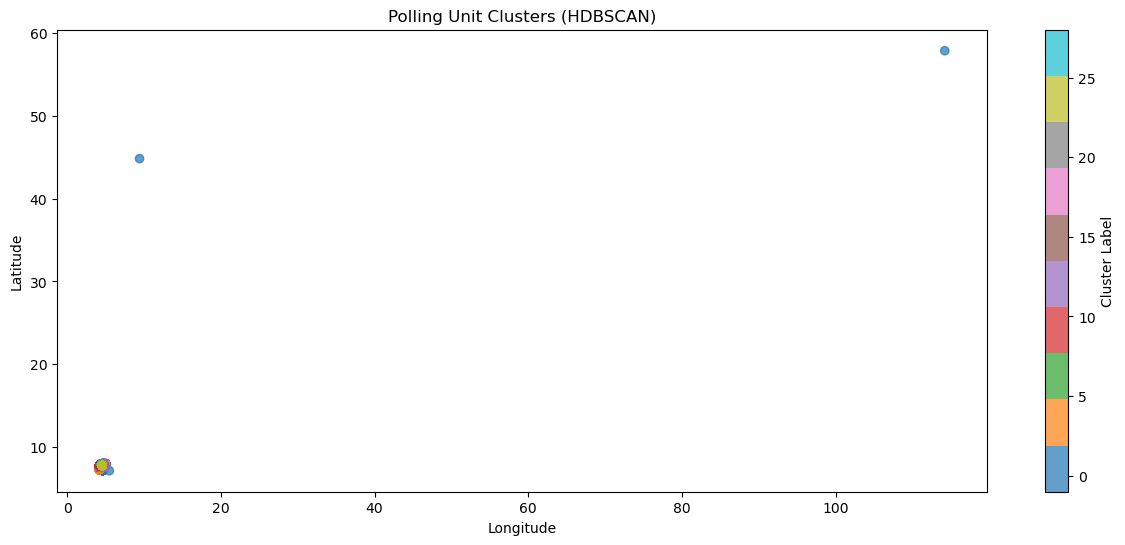

  State             LGA   Ward       PU-Code  \
0  OSUN  ATAKUMOSA EAST  IWARA  29-01-01-001   
1  OSUN  ATAKUMOSA EAST  IWARA  29-01-01-003   
2  OSUN  ATAKUMOSA EAST  IWARA  29-01-01-004   
3  OSUN  ATAKUMOSA EAST  IWARA  29-01-01-007   
4  OSUN  ATAKUMOSA EAST  IWARA  29-01-01-009   

                                             PU-Name  Accredited_Voters  \
0                                    TOWN HALL IWARA                181   
1                                L.A. SCHOOL, IWIKUN                245   
2                     METHODIST PRY. SCHOOL, AYETORO                117   
3                               OPEN SPACE ODO-IWARA                187   
4  OPEN SPACE INFRONT OF OSUN STATE GOVT. REVENUE...                 52   

   Registered_Voters  Results_Found  Transcription_Count  \
0                942           True                   -1   
1                881           True                   -1   
2                308           True                   -1   
3                538

30

In [94]:

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from geopy.distance import great_circle


# Read the updated file and save it as a dataframe again
df = pd.read_csv('OSUN_Geocoded_updated.csv')
# Convert to numpy array for clustering
coords = df[['Latitude', 'Longitude']].to_numpy()


# HDBSCAN Clustering
hdb = hdbscan.HDBSCAN(min_cluster_size=10, metric='haversine')
df['HDBSCAN_Cluster'] = hdb.fit_predict(np.radians(coords))

# Plot results
plt.figure(figsize=(15, 6))
plt.scatter(df['Longitude'], df['Latitude'], c=df['HDBSCAN_Cluster'], cmap='tab10', alpha=0.7)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Polling Unit Clusters (HDBSCAN)")
plt.colorbar(label="Cluster Label")
plt.show()

# Save results
df.to_csv('OSUN_Geocoded_Cluustered', index=False)

print(df.head())  # Show first few rows
df['HDBSCAN_Cluster'].nunique()

In [95]:
df['HDBSCAN_Cluster'].nunique()

30

# Clustering Analysis using DBSCAN

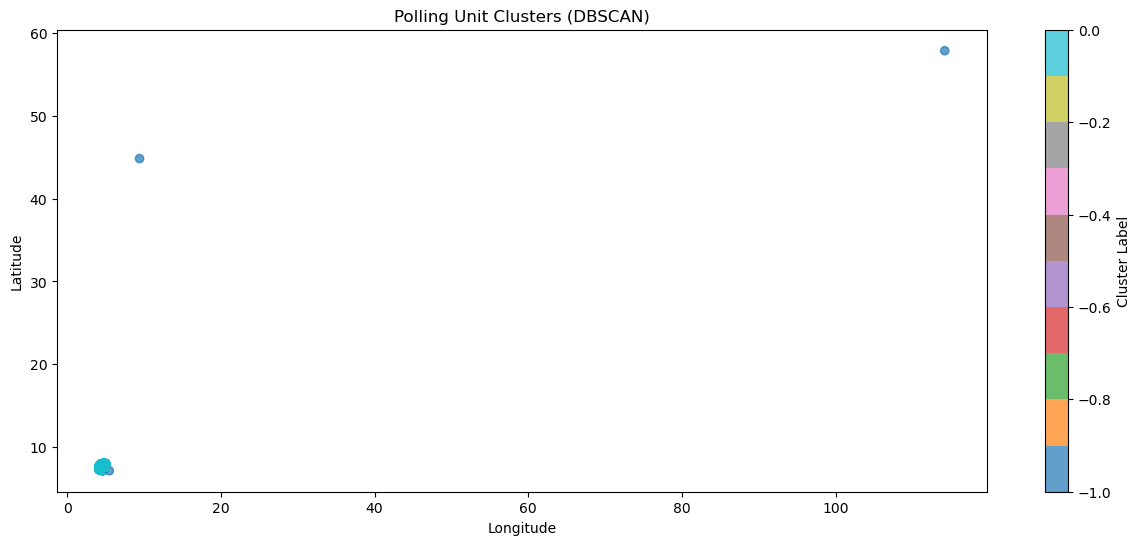

2

In [97]:

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from geopy.distance import great_circle

df2 = pd.read_csv('OSUN_Geocoded_updated.csv')
# Convert to numpy array for clustering
coords = df2[['Latitude', 'Longitude']].to_numpy()

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.01, min_samples=5, metric='haversine')  # Adjust eps as needed
df2['DBSCAN_Cluster'] = dbscan.fit_predict(np.radians(coords))  # Convert to radians for geospatial distance

# HDBSCAN Clustering
# hdb = hdbscan.HDBSCAN(min_cluster_size=10, metric='haversine')
# df2['HDBSCAN_Cluster'] = hdb.fit_predict(np.radians(coords))

# Plot results
plt.figure(figsize=(15, 6))
plt.scatter(df2['Longitude'], df2['Latitude'], c=df2['DBSCAN_Cluster'], cmap='tab10', alpha=0.7)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Polling Unit Clusters (DBSCAN)")
plt.colorbar(label="Cluster Label")
plt.show()

# Save results
df2.to_csv('clustered_dbscan_polling_units.csv', index=False)

df2['DBSCAN_Cluster'].nunique() # Show how many clusters were obtained


### Since the dbscan clustering gave just 2 clusters, it is not robust enough for this data and is therefore jettisoned

# Spatial Outlier Analysis

### Local Moran’s I to identify localized spatial autocorrelation.

C:\Users\DELL\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 28 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


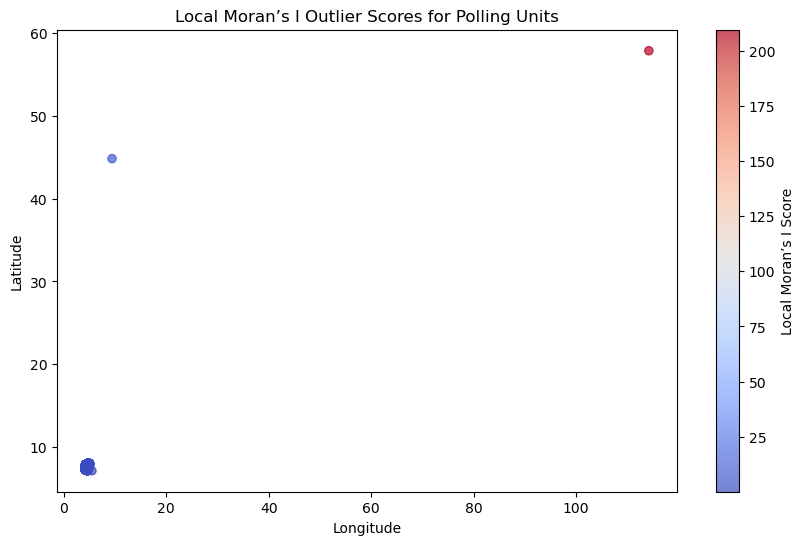

   Latitude  Longitude  Local_Moran_I  p_value     Cluster_Type
0       7.5        4.5       0.024315    0.055  Not Significant
1       7.5        4.5       0.024315    0.055  Not Significant
2       7.5        4.5       0.024315    0.055  Not Significant
3       7.5        4.5       0.024315    0.055  Not Significant
4       7.5        4.5       0.024315    0.055  Not Significant


In [106]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import KNN, Rook, Queen
from esda.moran import Moran_Local
from shapely.geometry import Point

# Load polling unit dataset (ensure it has 'Latitude' and 'Longitude' columns)
df = pd.read_csv('OSUN_Geocoded_Cluustered')

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")  # WGS 84 coordinate system

# Create spatial weights (using k-Nearest Neighbors with k=5)
knn_weights = KNN.from_dataframe(gdf, k=5)

# Compute Local Moran's I
moran_local = Moran_Local(gdf['Latitude'], knn_weights)

# Store the outlier scores (z-scores of Local Moran’s I)
gdf['Local_Moran_I'] = moran_local.Is
gdf['p_value'] = moran_local.p_sim  # P-value for significance testing
gdf['Cluster_Type'] = np.where(
    (moran_local.q == 1) & (moran_local.p_sim < 0.05), 'High-High',
    np.where((moran_local.q == 2) & (moran_local.p_sim < 0.05), 'Low-Low',
             np.where((moran_local.q == 3) & (moran_local.p_sim < 0.05), 'High-Low',
                      np.where((moran_local.q == 4) & (moran_local.p_sim < 0.05), 'Low-High', 'Not Significant'))))

# Save results to CSV
gdf.to_csv('polling_units_local_moran.csv', index=False)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(gdf['Longitude'], gdf['Latitude'], c=gdf['Local_Moran_I'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Local Moran’s I Score")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Local Moran’s I Outlier Scores for Polling Units")
plt.show()

# Display first few rows
print(gdf[['Latitude', 'Longitude', 'Local_Moran_I', 'p_value', 'Cluster_Type']].head())

C:\Users\DELL\AppData\Local\Temp\ipykernel_7176\1494243327.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=gdf["Cluster_Type"], order=gdf["Cluster_Type"].value_counts().index, palette="viridis")


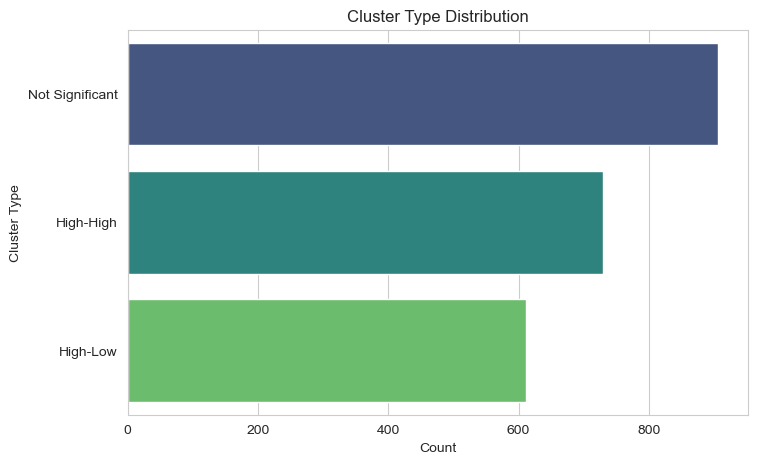

In [108]:
## Plot the distribution of the Local_Moran's spatial autocoreelation as a bar chart
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.countplot(y=gdf["Cluster_Type"], order=gdf["Cluster_Type"].value_counts().index, palette="viridis")

# Customize the plot
plt.title("Cluster Type Distribution")
plt.xlabel("Count")
plt.ylabel("Cluster Type")

# Show the plot
plt.show()


In [128]:
#  Tab_summary = pd.DataFrame((gdf['Cluster_Type'].value_counts()), columns = [['Cluster Type', 'Frequency']])
Tab =  (gdf['Cluster_Type'].value_counts())
#Tab_summary
Name = Tab.keys().to_list()

['Not Significant', 'High-High', 'High-Low']

In [132]:
aj = pd.DataFrame(['Name', 'Tab'])
aj

,0
0,Name
1,Tab


## Getis-Ord Gi(Hot Spot Analysis) to detect significant vote concentration.

In [137]:
import pandas as pd
import numpy as np
import geopandas as gpd
import libpysal as ps
import esda
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (Ensure your dataset has latitude & longitude)
df = pd.read_csv("polling_units_local_moran.csv")

# Convert to GeoDataFrame
geometry = gpd.points_from_xy(df["Longitude"], df["Latitude"])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Define spatial weights using K-Nearest Neighbors (KNN)
w = ps.weights.KNN.from_dataframe(gdf, k=8)  # k=8 defines neighbors
w.transform = "R"  # Row standardization

# Compute Getis-Ord Gi* statistic
g_star = esda.getisord.G_Local(gdf["Accredited_Voters"], w)

# Add Gi* values and p-values to the DataFrame
gdf["Gi_star"] = g_star.Zs  # Standardized Getis-Ord Gi*
gdf["p_value"] = g_star.p_sim  # P-values for significance

# Identify significant hot/cold spots
gdf["Hotspot_Type"] = "Not Significant"
gdf.loc[(gdf["Gi_star"] > 1.96) & (gdf["p_value"] < 0.05), "Hotspot_Type"] = "Hot Spot"
gdf.loc[(gdf["Gi_star"] < -1.96) & (gdf["p_value"] < 0.05), "Hotspot_Type"] = "Cold Spot"

# Plot results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=gdf, x="Longitude", y="Latitude", hue="Hotspot_Type", palette={"Hot Spot": "red", "Cold Spot": "blue", "Not Significant": "gray"}, alpha=0.6)
plt.title("Getis-Ord Gi* (Hot Spot Analysis)")
plt.legend(title="Hot Spot Type")
plt.show()


C:\Users\DELL\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 27 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


TypingError: [1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<intrinsic _impl>) found for signature:
 
 >>> _impl(array(int64, 2d, C), array(float64, 1d, C))
 
There are 2 candidate implementations:
[1m  - Of which 2 did not match due to:
  Intrinsic in function 'dot_2_impl.<locals>._impl': File: numba\np\linalg.py: Line 543.
    With argument(s): '(array(int64, 2d, C), array(float64, 1d, C))':[0m
[1m   Rejected as the implementation raised a specific error:
     TypingError: [1m'@' arguments must all have the same dtype[0m[0m
  raised from C:\Users\DELL\anaconda3\Lib\site-packages\numba\np\linalg.py:563
[0m
[0m[1mDuring: resolving callee type: Function(<intrinsic _impl>)[0m
[0m[1mDuring: typing of call at C:\Users\DELL\anaconda3\Lib\site-packages\numba\np\linalg.py (582)
[0m
[1m
File "..\..\..\..\anaconda3\Lib\site-packages\numba\np\linalg.py", line 582:[0m
[1m            def _dot2_codegen(context, builder, sig, args):
                <source elided>

[1m        return lambda left, right: _impl(left, right)
[0m        [1m^[0m[0m

[0m[1mDuring: typing of intrinsic-call at C:\Users\DELL\anaconda3\Lib\site-packages\esda\getisord.py (683)[0m
[1m
File "..\..\..\..\anaconda3\Lib\site-packages\esda\getisord.py", line 683:[0m
[1mdef _g_local_crand(i, z, permuted_ids, weights_i, scaling):
    <source elided>
    zi, zrand = _prepare_univariate(i, z, permuted_ids, other_weights)
[1m    return (zrand @ other_weights) / (scaling - zi)
[0m    [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _g_local_crand at 0x000001F202C77E20>))[0m
[0m[1mDuring: typing of call at C:\Users\DELL\anaconda3\Lib\site-packages\esda\crand.py (325)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _g_local_crand at 0x000001F202C77E20>))[0m
[0m[1mDuring: typing of call at C:\Users\DELL\anaconda3\Lib\site-packages\esda\crand.py (325)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function _g_local_crand at 0x000001F202C77E20>))[0m
[0m[1mDuring: typing of call at C:\Users\DELL\anaconda3\Lib\site-packages\esda\crand.py (325)
[0m
[1m
File "..\..\..\..\anaconda3\Lib\site-packages\esda\crand.py", line 325:[0m
[1mdef compute_chunk(
    <source elided>
        mask[chunk_start + i] = False
[1m        rstats = stat_func(chunk_start + i, z, permuted_ids, weights_i, scaling)
[0m        [1m^[0m[0m
[0m

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248 entries, 0 to 2247
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2248 non-null   object 
 1   LGA                     2248 non-null   object 
 2   Ward                    2248 non-null   object 
 3   PU-Code                 2248 non-null   object 
 4   PU-Name                 2248 non-null   object 
 5   Accredited_Voters       2248 non-null   int64  
 6   Registered_Voters       2248 non-null   int64  
 7   Results_Found           2248 non-null   bool   
 8   Transcription_Count     2248 non-null   int64  
 9   Result_Sheet_Stamped    2248 non-null   bool   
 10  Result_Sheet_Corrected  2248 non-null   bool   
 11  Result_Sheet_Invalid    2248 non-null   bool   
 12  Result_Sheet_Unclear    2248 non-null   bool   
 13  Result_Sheet_Unsigned   2248 non-null   object 
 14  APC                     2248 non-null   

C:\Users\DELL\anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 27 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


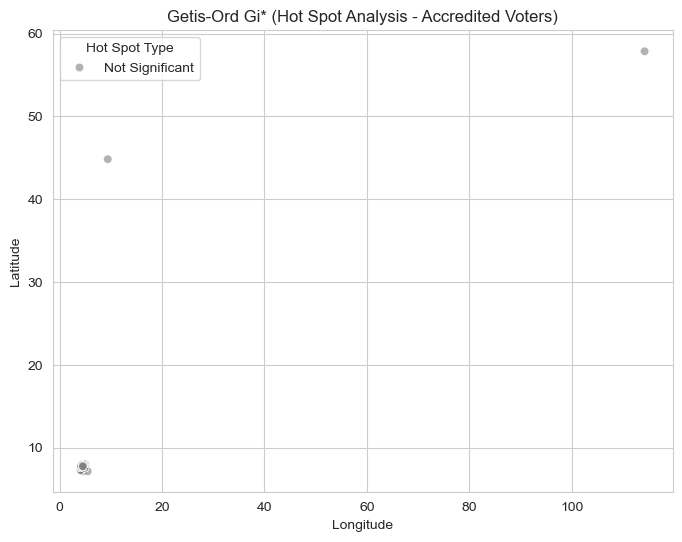

In [144]:
import pandas as pd
import numpy as np
import geopandas as gpd
import libpysal as ps
import esda
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("polling_units_local_moran.csv")

# Ensure "Accredited Voters", Longitude, and Latitude are numeric
df["Accredited_Voters"] = pd.to_numeric(df["Accredited_Voters"], errors="coerce")
df["Longitude"] = pd.to_numeric(df["Longitude"], errors="coerce")
df["Latitude"] = pd.to_numeric(df["Latitude"], errors="coerce")

# Drop rows with missing values
df = df.dropna(subset=["Accredited_Voters", "Longitude", "Latitude"])

# Convert to GeoDataFrame
geometry = gpd.points_from_xy(df["Longitude"], df["Latitude"])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Define spatial weights using K-Nearest Neighbors (KNN)
w = ps.weights.KNN.from_dataframe(gdf, k=8)  # Adjust k as needed
w.transform = "R"  # Row standardization


# Compute Getis-Ord Gi* statistic
g_star = esda.getisord.G_Local(gdf["Accredited_Voters"].astype(float), w)


# Add Gi* values and p-values to the DataFrame
gdf["Gi_star"] = g_star.Zs  # Standardized Getis-Ord Gi*
gdf["pGO_value"] = g_star.p_sim  # P-values for significance

# Identify significant hot/cold spots
gdf["Hotspot_Type"] = "Not Significant"
gdf.loc[(gdf["Gi_star"] > 1.96) & (gdf["pGO_value"] < 0.05), "Hotspot_Type"] = "Hot Spot"
gdf.loc[(gdf["Gi_star"] < -1.96) & (gdf["pGO_value"] < 0.05), "Hotspot_Type"] = "Cold Spot"

# Plot results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=gdf, x="Longitude", y="Latitude", hue="Hotspot_Type", 
                palette={"Hot Spot": "red", "Cold Spot": "blue", "Not Significant": "gray"}, alpha=0.6)
plt.title("Getis-Ord Gi* (Hot Spot Analysis - Accredited Voters)")
plt.legend(title="Hot Spot Type")
plt.show()


In [140]:
df["Accredited_Voters"] = pd.to_numeric(df["Accredited_Voters"], errors="coerce").astype(float)

In [145]:
gdf.columns

Index(['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Accredited_Voters',
       'Registered_Voters', 'Results_Found', 'Transcription_Count',
       'Result_Sheet_Stamped', 'Result_Sheet_Corrected',
       'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned',
       'APC', 'LP', 'PDP', 'NNPP', 'Results_File', 'Latitude', 'Longitude',
       'HDBSCAN_Cluster', 'geometry', 'Local_Moran_I', 'p_value',
       'Cluster_Type', 'Gi_star', 'pGO_value', 'Hotspot_Type'],
      dtype='object')

In [146]:
gdf.to_csv('Vote and location concentration.csv')

In [147]:
gdf["Hotspot_Type"].value_counts()

Hotspot_Type
Not Significant    2248
Name: count, dtype: int64

In [2]:
import pandas as pd
import numpy as np

In [3]:
dg = pd.read_csv('Vote and location concentration.csv')

In [5]:
dg.columns

Index(['Unnamed: 0', 'State', 'LGA', 'Ward', 'PU-Code', 'PU-Name',
       'Accredited_Voters', 'Registered_Voters', 'Results_Found',
       'Transcription_Count', 'Result_Sheet_Stamped', 'Result_Sheet_Corrected',
       'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned',
       'APC', 'LP', 'PDP', 'NNPP', 'Results_File', 'Latitude', 'Longitude',
       'HDBSCAN_Cluster', 'geometry', 'Local_Moran_I', 'p_value',
       'Cluster_Type', 'Gi_star', 'pGO_value', 'Hotspot_Type'],
      dtype='object')

In [8]:
dg['LGA'].nunique()

30

In [11]:
dg['Cluster_Type'].value_counts()

Cluster_Type
Not Significant    906
High-High          730
High-Low           612
Name: count, dtype: int64

In [16]:
df1=dg[dg['Cluster_Type']=='High-Low']

In [17]:
df1['HDBSCAN_Cluster'].value_counts()

HDBSCAN_Cluster
7    161
1     94
3     90
0     78
2     71
5     66
4     52
Name: count, dtype: int64

In [18]:
dg['HDBSCAN_Cluster'].value_counts()

HDBSCAN_Cluster
 25    190
 7     161
 11    113
 28    106
 6     101
 19    101
 1      94
 20     92
 3      90
 17     87
 14     79
 0      78
 9      75
 22     73
 2      71
 24     71
 21     68
 5      66
 23     66
 13     63
 16     62
 26     56
 4      52
 18     48
 27     45
 10     45
 8      41
 15     39
 12     11
-1       4
Name: count, dtype: int64

In [19]:
from sklearn.ensemble import IsolationForest
import numpy as np

df = pd.read_csv('Vote and location concentration.csv')
# Selecting relevant numerical features for anomaly detection
features = ["Accredited_Voters", "Registered_Voters", "APC", "LP", "PDP", "NNPP", "SUM", "Latitude", "Longitude"]
data = df[features]

# Handling potential missing values
data = data.fillna(data.median())

# Applying Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df["Anomaly_Score"] = iso_forest.fit_predict(data)

# Mapping anomaly labels (-1: anomaly, 1: normal)
df["Anomaly_Label"] = np.where(df["Anomaly_Score"] == -1, "Anomalous", "Normal")

# Display anomaly summary
df["Anomaly_Label"].value_counts()


Anomaly_Label
Normal       2135
Anomalous     113
Name: count, dtype: int64

In [33]:
df.to_csv('Vote and location concentration.csv', index = False)

In [26]:
df.drop(columns = ['Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis = 1)

,Unnamed: 0,State,Accredited_Voters,Registered_Voters,APC,LP,PDP,NNPP,SUM,Latitude,...,HDBSCAN_Cluster,geometry,Local_Moran_I,p_value,Cluster_Type,Gi_star,pGO_value,Hotspot_Type,Anomaly_Score,Anomaly_Label
0,239,OSUN,180,407,63,8,105,0,176,7.91891,...,15,POINT (4.81303 7.91891),0.024760,0.006,High-High,-0.908176,0.005,Not Significant,1,Normal
1,240,OSUN,138,294,65,2,81,0,148,7.91891,...,15,POINT (4.81303 7.91891),0.024760,0.006,High-High,-0.908559,0.005,Not Significant,1,Normal
2,241,OSUN,121,213,49,3,68,0,120,7.91891,...,15,POINT (4.81303 7.91891),0.024760,0.006,High-High,-0.908744,0.005,Not Significant,1,Normal
3,242,OSUN,138,243,38,2,68,0,108,7.91891,...,15,POINT (4.81303 7.91891),0.024760,0.006,High-High,-0.908559,0.005,Not Significant,1,Normal
4,243,OSUN,116,234,46,2,66,0,114,7.91891,...,15,POINT (4.81303 7.91891),0.024760,0.006,High-High,-0.908802,0.005,Not Significant,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,2243,OSUN,246,586,134,5,100,1,240,7.77104,...,25,POINT (4.55698 7.77104),0.002187,0.145,Not Significant,-0.108141,0.377,Not Significant,1,Normal
2244,2244,OSUN,139,179,46,4,50,1,101,7.77104,...,25,POINT (4.55698 7.77104),0.002187,0.145,Not Significant,-0.108740,0.377,Not Significant,1,Normal
2245,2245,OSUN,139,179,25,5,44,1,75,7.77104,...,25,POINT (4.55698 7.77104),0.002187,0.145,Not Significant,-0.108740,0.377,Not Significant,1,Normal
2246,2246,OSUN,139,179,11,1,40,0,52,7.77104,...,25,POINT (4.55698 7.77104),0.002187,0.145,Not Significant,-0.108740,0.377,Not Significant,1,Normal


In [32]:
# Re-import necessary libraries for mapping
import folium

# Define the map center
map_center = [df["Latitude"].mean(), df["Longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Add data points to the map
for _, row in df.iterrows():
    color = "red" if row["Anomaly_Label"] == "Anomalous" else "blue"
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
    ).add_to(m)

# Save the map
map_path = "/mnt/data/anomaly_map.html"
m.save(map_path)
map_path

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/anomaly_map.html'

In [29]:
!pip install folium